$\texttt{NBA-DATAMINING.csv}$ contains stats for NBA games from 2011 to 2018.  The goal is to predict the winner of any game with better than 50% accuracy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [155]:
data = pd.read_csv('NBA_DATAMINING.csv')
data.head()

,date,team,points,assists,biggest lead,blocks,defensive rebounds,fast break points,field goals attempted,field goals made,fouls,free throws attempted,free throws made,game number,lead changes,losses,margin,margin after the first,margin after the third,margin at the half,matchup losses,matchup wins,offensive rebounds,playoffs,points in the paint,rebounds,rest,site,site streak,steals,streak,team rebounds,three pointers attempted,three pointers made,times tied,total,turnovers,wins,o:team,o:points,o:assists,o:biggest lead,o:blocks,o:defensive rebounds,o:fast break points,o:field goals attempted,o:field goals made,o:fouls,o:free throws attempted,o:free throws made,o:losses,margin.1,o:margin after the first,o:margin after the third,o:margin at the half,o:matchup losses,o:matchup wins,o:offensive rebounds,o:points in the paint,o:rebounds,o:rest,o:site,o:site streak,o:steals,o:streak,o:team rebounds,o:three pointers attempted,o:three pointers made,o:turnovers,o:wins,season
0,20091115,Lakers,91,23,14,10,32,18,84,32,17,27,20,10,10,2,-10,6,-7,2,0,1,6,0,40,38,1,home,-1,10,-1,9,23,7,7,201.0,13,7,Rockets,101,27,13,6,47,14,91,38,24,19,16,4,-10,-6,7,-2,1,0,13,44,60,1,away,-1,9,-1,8,32,9,19,5,2009
1,20091115,Pistons,90,12,7,6,32,6,83,38,19,17,12,10,13,4,-5,-4,-5,6,0,0,12,0,46,44,0,home,-1,4,3,12,13,2,7,184.5,13,5,Mavericks,95,25,8,7,27,14,82,36,15,21,16,3,-5,4,5,-6,0,0,11,36,38,1,away,-2,11,1,7,16,7,7,6,2009
2,20091115,Suns,101,18,7,4,34,10,78,35,16,27,23,11,6,2,1,-2,-2,-3,0,0,12,0,38,46,2,home,-1,3,-1,8,24,8,11,232.5,15,8,Raptors,100,18,10,4,28,4,88,40,20,14,11,4,1,2,2,3,0,0,11,40,39,1,away,-1,6,2,5,24,9,11,5,2009
3,20091115,Thunder,93,13,3,1,30,10,85,33,25,29,24,10,25,4,-8,-3,1,-8,0,1,18,0,40,48,0,home,-3,7,2,7,20,3,18,183.0,12,5,Clippers,101,17,13,4,30,10,79,38,21,28,20,7,-8,3,-1,8,1,0,12,46,42,1,away,4,9,-3,9,17,5,12,3,2009
4,20091116,Bucks,113,26,2,4,33,18,99,44,21,17,11,8,8,2,-2,-5,-3,-12,0,0,14,0,42,47,1,home,3,10,4,6,27,14,8,193.0,10,5,Mavericks,115,28,18,3,39,9,86,44,19,22,17,3,-2,5,3,12,0,0,9,40,48,0,away,-3,5,2,7,20,10,15,7,2009


Each row has the results of each game.  In order to preict games faithfully we can't steal from the future,
i.e. we can't use the results of the game to predict the outcome.

In [156]:
def make_target(data):
    """
    Determine which team won; return 1 for home team, 0 for opponent 
    """
        
    if data['points'] > data['o:points']:
        return 1
    else:
        return 0

In [157]:
data['points last 10'] = 0.0
data['o:points last 10'] = 0.0

In [158]:
#  build feature columns

#  make target
data['won'] = data.apply(make_target, axis=1)

#  win ratios for home and opponent
data['win_ratio'] = data['wins'] / data['game number']
data['o:win_ratio'] = data['o:wins'] / data['game number']

#  sum of points in previous 10 games ... this takes a few seconds
for team in data['team'].unique():

    #  find all the points they scored at home
    home_points = data.loc[data['team'] == team, 'points']
    
    #  find all the points they scored away
    away_points = data.loc[data['o:team'] == team, 'o:points']
    
    #  rolling sum of last 10
    points_last_10 = pd.concat([home_points, away_points]).sort_index().rolling(10).sum()
    
    #  add sum to the corresponding team/index
    for idx in points_last_10.index:
        points = points_last_10[idx]
        
        if data.iloc[idx]['team'] == team:
            data.at[idx, 'points last 10'] = 0.0 if np.isnan(points) else points
        else:
            data.at[idx, 'o:points last 10'] = 0.0 if np.isnan(points) else points


In [162]:
# I'll put stats for each season/team/predictor in a dictionary: 
team_season_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

In [163]:
def get_predictors_for_team(season, team, predictorname):
    """
    Grab the value of a given predictor from the stats dictionary
    
    int season - year during which the season took place, e.g. 2011
    str team - team name, e.g. 'Bulls'
    str predictorname - predictor to return for given team & season, e.g. 'points'
    """
    
    predictor = team_season_stats[season][team][predictorname]
    
    #  see if predictor has many entries
    try: len(predictor)
    except: return predictor
    
    #  if it has one entry, return it
    if len(predictor) == 0:
        return 
    
    #  if it has many, return the most recent one
    else:
        return predictor[-1]


In [164]:

def elo(R1, R2, S):
    """
    Calculate the Elo score for competing teams given the outcome
    
    float R1 - previous Elo score of team 1
    float R2 - previous Elo score of team 2
    int S - result of the matchup; 1 for home win, 0 for opponent win
    """
    
    #set k factor:
    k = 20.;
    
    #transformed ratings:
    r1 = np.power(10, (R1/400.))
    r2 = np.power(10, (R2/400.))
    
    #expected scores:
    e1 = r1 / (r1 + r2)
    e2 = r2 / (r1 + r2)
    
    #set s1, s2 based on outcome:
    s1 = int(S==1)
    s2 = int(S!=1)
    
    #updated elo ratings
    new_R1 = R1 + k * (s1 - e1)
    new_R2 = R2 + k * (s2 - e2)

    
    return new_R1, new_R2

In [165]:
#lets just start with a few predictors
predictors = ['wins','o:wins',
              'win_ratio','o:win_ratio',
              'points','o:points',
              'points last 10','o:points last 10',
              'assists','o:assists',
              'turnovers','o:turnovers',
              'streak','o:streak',
              'offensive rebounds','o:offensive rebounds',
              'elo', 'o:elo']

In [168]:
def build_data(all_data):
    # X and y WILL CONTAIN OUR DATAxPREDICTORS and TARGETS RESPECTIVELY
    # X and y will eventually be fed into scikit learn 
    
    # X is 2D (datasamples x predictors)
    # y are the 1D target values (0 or 1 for win or loss, TARGETS)
    
    # return X, y, season - "season" correspond to the season in which each data sample falls. 
    # season should have the exact same dimensions as y
    
    X = []
    y = []
    season = []

    #  set initial Elos in the stats dictionary
    for s in np.unique(data['season']): 
        for team in np.unique(data['team']): 
            team_season_stats[s][team]['elo'] = 1000
    
    #  just for fun I want to see how elo changes over each season
    elo_over_time = defaultdict(lambda: defaultdict(list))

    #  split predictors for home and away teams
    #  exclude Elo because it's not in the dataframe
    home_predictors = [i for i in predictors if i[:2] != 'o:' and i != 'elo']
    away_predictors = [i for i in predictors if i[:2] == 'o:' and i != 'o:elo']
    
    for index, row in all_data.iterrows(): 
        
        #  get values of predictors for each matchup.  
        #  IMPORTANTLY, values come from the stats dictionary which is
        #  updated AFTER each row is added to X, so there is no stolen 'future' data
        new_team_data = [get_predictors_for_team(row['season'], row['team'], i) for i in home_predictors]
        new_oteam_data = [get_predictors_for_team(row['season'], row['o:team'], i) for i in home_predictors]
        new_team_data.append(team_season_stats[row['season']][row['team']]['elo'])
        new_oteam_data.append(team_season_stats[row['season']][row['o:team']]['elo'])
        
        # some of the rows will not contain predictors.  don't use these
        if (None not in new_team_data) and (None not in new_oteam_data): 
            X.append(new_team_data + new_oteam_data)
            y.append(row['won'])
            season.append(row['season'])
        
        #stats to be updated for home/away teams
        home_stats = {}
        for predictor in home_predictors:
            home_stats[predictor] = row[predictor]

        away_stats = {}
        for predictor in away_predictors:
            away_stats[predictor[2:]] = row[predictor]

        #update stats for each team.  
        #'o:team's stats count under its 'predictor' columns rather than under 'o:predictor'
        for predictor in home_predictors:
            team_season_stats[row['season']][row['team']][predictor].append(home_stats[predictor])
            team_season_stats[row['season']][row['o:team']][predictor].append(home_stats[predictor])
            
        #update Elo scores
        home_elo = team_season_stats[row['season']][row['team']]['elo']
        away_elo = team_season_stats[row['season']][row['o:team']]['elo']
        
        new_elos = elo(home_elo, away_elo, row['won'])
        
        team_season_stats[row['season']][row['team']]['elo'] = new_elos[0]
        team_season_stats[row['season']][row['o:team']]['elo'] = new_elos[1]
        
        #just for fun: update elo over time
        elo_over_time[row['season']][row['team']].append(home_elo)
        elo_over_time[row['season']][row['o:team']].append(away_elo)
        
    X = np.vstack(X)
    return X, y, season


In [169]:
import time
t1 = time.time()
X, y, season = build_data(data)
t2 = time.time()
print('time to build data:', t2-t1)

time to build data: 15.291289806365967


(11177, 18)
11177
11177


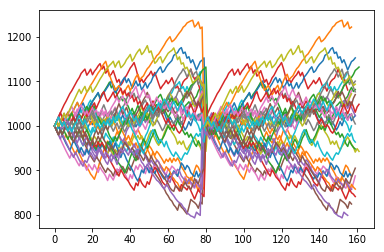

In [170]:
print(X.shape)
print(len(y))
print(len(season))
for t in team_season_stats[2017].keys():
    plt.plot(elo_over_time[2017][t], label=t)
# plt.legend()
# plt.savefig('elos_over_2016.pdf')
plt.show()

 ** Fitting **
 
 now that we have filled our data, features and targets, we can feed this in to scikit learn logistic regression.

In [171]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# This is scikit learn log regression model. 
# We just need to feed it data and train!
model = linear_model.LogisticRegression() 
# random_forest = RandomForestClassifier(n_estimators=100)

season = np.array(season,dtype='int')

# splitting up train and test data
train = np.array(season) != 2017
test = np.array(season) == 2017

model.fit(np.array(X)[train], np.array(y)[train]) #This is the training.
# random_forest.fit(np.array(X)[train], np.array(y)[train])

print('Model done fitting!')
print('Logistic Regression Training Accuracy %.3f'%(model.score(np.array(X)[train,:],np.array(y)[train])))
# print('Random Forest Training Accuracy %.3f'%(random_forest.score(np.array(X)[train,:],np.array(y)[train])))
# print(random_forest.feature_importances_)

Model done fitting!
Logistic Regression Training Accuracy 0.661


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [172]:
print ('2017 Season Test Accuracy (Logistic Regression) %.3f'%(model.score(np.array(X)[test,:],np.array(y)[test])))
# print ('2017 Season Test Accuracy (Random Forest) %.3f'%(random_forest.score(np.array(X)[test,:],np.array(y)[test])))

2017 Season Test Accuracy (Logistic Regression) 0.645
